In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from anonymeter.evaluators import SinglingOutEvaluator
from anonymeter.evaluators import LinkabilityEvaluator
from anonymeter.evaluators import InferenceEvaluator

/Users/ivanananevski/projects/anonymeter/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import warnings
warnings.filterwarnings('ignore')

## Downloading the data

For this example, we will use the famous `Adults` (more details [here](https://archive.ics.uci.edu/ml/datasets/adult)) dataset. This dataset contains aggregated census data, where every row represent a population segment. For the purpose of demonstrating `Anonymeter`, we will use this data as if each row would in fact refer to a real individual. 

The synthetic version has been generated by `CTGAN` from [SDV](https://sdv.dev/SDV/user_guides/single_table/ctgan.html), as explained in the paper accompanying this code release. For details on the generation process, e.g. regarding hyperparameters, see Section 6.2.1 of [the accompanying paper](https://petsymposium.org/popets/2023/popets-2023-0055.php)).

We pull these datasets from the [Statice](https://www.statice.ai/) public GC bucket:

In [4]:
ori = pd.read_csv(Path.home() / "projects/synthetic_data/original/adult/train.csv")
syn = pd.read_csv(Path.home() / "projects/synthetic_data/synthetic/adult/ARF.csv")
control = pd.read_csv(Path.home() / "projects/synthetic_data/original/adult/test.csv")

In [5]:
ori.head()

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,37,Private,193106,Bachelors,13,Never-married,Sales,Not-in-family,White,Female,0,0,30,United-States,<=50K
1,56,Self-emp-inc,216636,12th,8,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1651,40,United-States,<=50K
2,53,Private,126977,HS-grad,9,Separated,Craft-repair,Not-in-family,White,Male,0,0,35,United-States,<=50K
3,72,Private,205343,11th,7,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
4,46,State-gov,106705,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,38,United-States,<=50K


As visible the dataset contains several demographic information, as well as information regarding the education, financial situation, and personal life of some tens of thousands of "individuals".

# Measuring the Inference Risk

Finally, `anonymeter` allows to measure the inference risk. It does so by measuring the success of an attacker that tries to discover the value of some secret attribute for a set of target records on which some auxiliary knowledge is available.

Similar to the case of the `LinkabilityEvaluator`, the main parameter here is `aux_cols` which specify what the attacker knows about its target, i.e. which columns are known to the attacker. By selecting the `secret` column, one can identify which attributes, alone or in combinations, exhibit the largest risks and thereby expose a lot of information on the original data.

In the following snippet we will measure the inference risk for each column individually, using all the other columns as auxiliary information to model a very knowledgeable attacker. 

In [31]:
columns = ori.columns[:5]
results = []

results_for_groups = {}

for secret in columns:
    
    aux_cols = [col for col in columns if col != secret]
    
    regression = True if ori[secret].dtype.kind in 'iuf' else False
    
    evaluator = InferenceEvaluator(ori=ori, 
                                   syn=syn, 
                                   control=control,
                                   aux_cols=aux_cols,
                                   secret=secret,
#                                    n_attacks=ori.shape[0],
                                   n_attacks=100,
                                   regression = regression,
                                   nn="neural_network")
    evaluator.evaluate(n_jobs=-2)
    results_for_groups[secret] = evaluator.risk_for_groups()
    results.append((secret, evaluator.results()))

No path specified. Models will be saved in: "AutogluonModels/ag-20250513_130441"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.9.22
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 24.4.0: Fri Apr 11 18:28:23 PDT 2025; root:xnu-11417.101.15~117/RELEASE_X86_64
CPU Count:          12
Memory Avail:       6.50 GB / 16.00 GB (40.6%)
Disk Space Avail:   226.54 GB / 465.63 GB (48.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accura

	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])    : 5 | ['Fnlwgt', 'Education-num', 'Capital-gain', 'Capital-loss', 'Hours-per-week']
		('object', []) : 9 | ['Workclass', 'Education', 'Marital-status', 'Occupation', 'Relationship', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('category', [])  : 7 | ['Workclass', 'Education', 'Marital-status', 'Occupation', 'Relationship', ...]
		('int', [])       : 5 | ['Fnlwgt', 'Education-num', 'Capital-gain', 'Capital-loss', 'Hours-per-week']
		('int', ['bool']) : 2 | ['Sex', 'Income']
	0.2s = Fit runtime
	14 features in original data used to generate 14 features in processed data.
	Train Data (Processed) Memory Usage:

Beginning AutoGluon training ...
AutoGluon will save models to "/Users/ivanananevski/projects/anonymeter/notebooks/AutogluonModels/ag-20250513_130722"
Train Data Rows:    39073
Train Data Columns: 14
Label Column:       Workclass
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	9 unique label values:  ['Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'Not-Specified', 'Self-emp-inc', 'State-gov', 'Never-worked', 'Without-pay']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       multiclass
Preprocessing data ...
Fraction of data from classes with at least 10 examples that will be kept for training models: 0.9998464412765848
Train Data Class Count: 8
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Av

	40.22s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'NeuralNetTorch': 1.0}
	-103477.939	 = Validation score   (-root_mean_squared_error)
	0.0s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 40.57s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 154147.9 rows/s (2500 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/Users/ivanananevski/projects/anonymeter/notebooks/AutogluonModels/ag-20250513_130754")
No path specified. Models will be saved in: "AutogluonModels/ag-20250513_130834"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.9.22
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 24.4.0: Fri Apr 11 18:28:23 PDT 2025; root:xnu-11417.101.15~117/RELEASE_X86_64
CPU Count:          12
Memory A

		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])    : 6 | ['Age', 'Fnlwgt', 'Education-num', 'Capital-gain', 'Capital-loss', ...]
		('object', []) : 8 | ['Workclass', 'Marital-status', 'Occupation', 'Relationship', 'Race', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('category', [])  : 6 | ['Workclass', 'Marital-status', 'Occupation', 'Relationship', 'Race', ...]
		('int', [])       : 6 | ['Age', 'Fnlwgt', 'Education-num', 'Capital-gain', 'Capital-loss', ...]
		('int', ['bool']) : 2 | ['Sex', 'Income']
	0.2s = Fit runtime
	14 features in original data used to generate 14 features in processed data.
	Train Data (Processed) Memory Usage: 2.09 MB (0.0% of available memory)
Data preprocessing and feature engineering ru

Train Data Rows:    39073
Train Data Columns: 14
Label Column:       Education-num
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	First 10 (of 16) unique label values:  [9, 10, 13, 7, 4, 14, 12, 3, 5, 11]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 16
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    6223.24 MB
	Train Data (Original)  Memory Usage: 23.62 MB (0.4% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator.

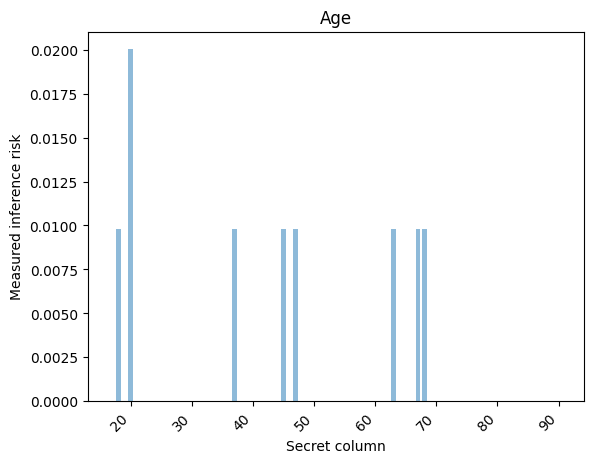

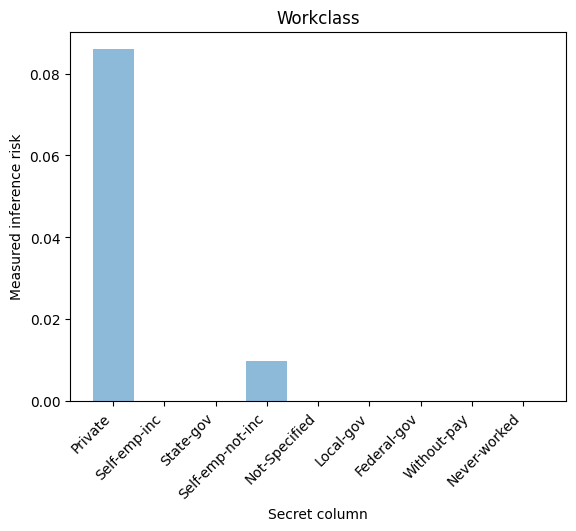

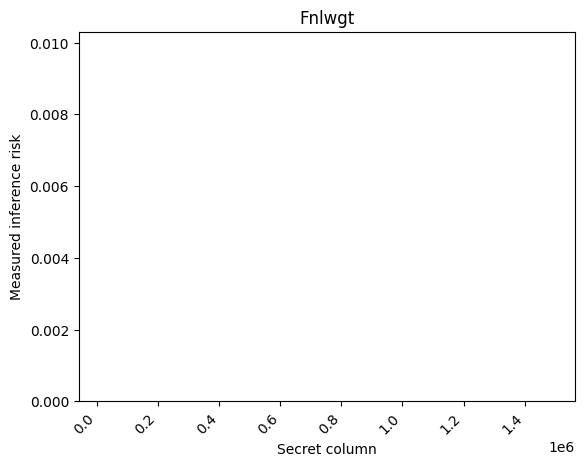

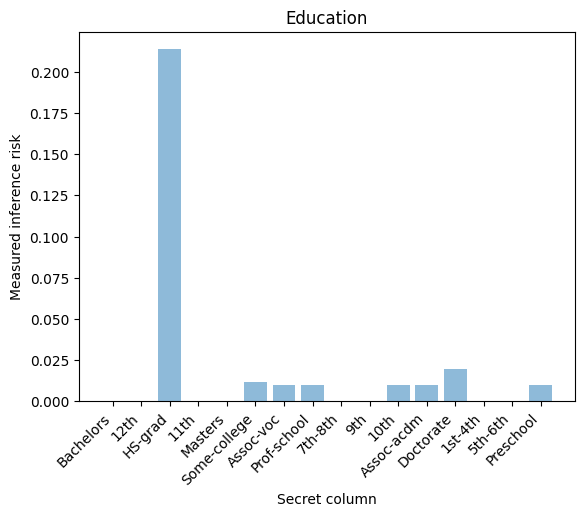

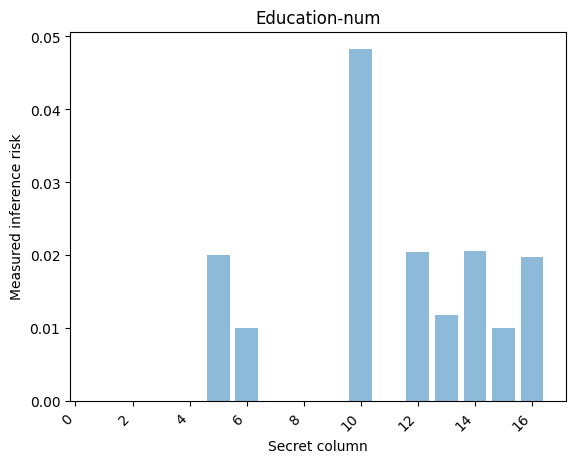

In [35]:
for secret in columns:
    curr_res = results_for_groups[secret]

    fig, ax = plt.subplots()

    risks = [res["risk"].value for _, res in curr_res.items()]
    columns = [key for key,_ in curr_res.items()]

    ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

    plt.xticks(rotation=45, ha='right')
    plt.title(secret)
    ax.set_ylabel("Measured inference risk")
    _ = ax.set_xlabel("Secret column")

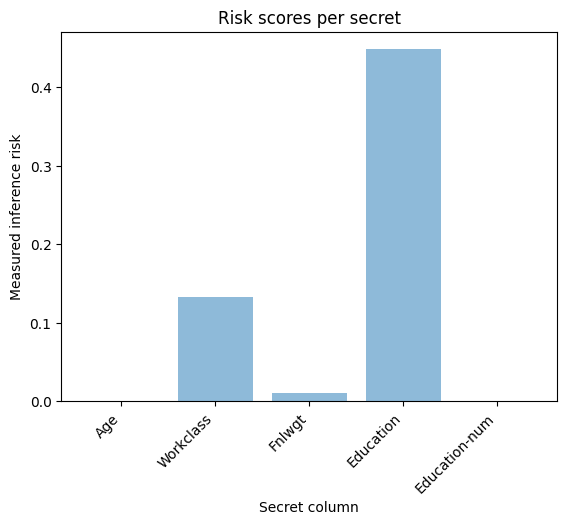

In [34]:
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
plt.title("Risk scores per secret")
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")